# Confidence Intervals and Bootstrapping
The concepts of confidence intervals and bootstrapping are linked by the definition of a p-value. Here I paraphrase the definition from Wikipedia, making it a bit shorter (and hopefully not loose meaning):

**P-value:** _The probability of observing this result or a more extreme one, under the null-hypothesis._

That is: if you'd do the same experiment over and over, many times, and there was actually no effect, what percentage of your results would be as extreme as this one or more extreme. If that percentage (probability) is very low, then it is less likely that there is no effect.

## T-tests

Let's unpack this a bit more with a common t-test, which we can get from `scipy`. We'll also need some data, which we will simply simulate for now, so we'll also import some stuff to handle random numbers from numpy.


In [0]:
from scipy import stats, int16
from numpy import random

We will simulate 15 IQ-scores and test if they are higher than 100: the theoretical population mean. The population should have a standard deviation of 15, which we will use, but we'll use a mean of 111, to see if a t-test can detect this.

In [14]:
random.seed(15)
IQ = int16((random.randn(15)*15)+111)
print(IQ)

[106 116 108 103 114  84  94  94 106 103 107 116 121 117 102]


Many scores are below the population mean, and many above, but is the mean of this group different from the theoretical mean? Let's run that t-test:

In [15]:
print(stats.ttest_1samp(IQ, 100))

Ttest_1sampResult(statistic=2.332238334289815, pvalue=0.03513184018915716)


Since the p-value is below 0.05 (the usual alpha) we can conclude that this sample's IQ scores are very likely different from the population mean (not higher, since this is a two-sided t-test). That is, we can reject the null-hypothesis (that this sample has a mean of 100). And if we're cheeky about it, we could even accept the alternative hypothesis.

This p-value is calculated with the Student t distribution (or sample t distribution). I'll show this distribution first, using `scipy.stats.t` which has a lot of functions for dealing with the t distribution. The t distribution only needs one shape parameter: `df`, os degrees of freedom. Which in our case is 15-1=14. We'll plot the probability density function across a range of z-scores (or quantiles). An array of z-score values is the first argument for the probability density function.

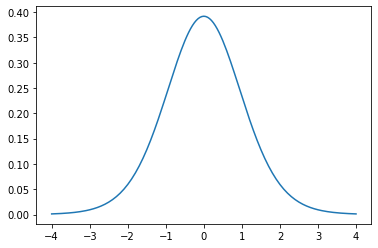

In [28]:
from numpy import arange
step = .05
# this generates the quantiles or z-scores
zscores = arange(-4, 4+step, step)
# here we calculate the probabilities of those quantiles in the t-distribution:
pds = stats.t.pdf(zscores, 14)
import pylab
pylab.plot(zscores, pds)
pylab.show()

If you've taken any statistics courses, this should look familiar. The y-axis here does not equal p-values, by the way (it's the proportion of the surface that falls within +/- some quantile). But we can use the t-statistic to calculate the p-value using another function in `scipy.stats.t`:

In [32]:
print((1 - stats.t.cdf(2.332238334289815, 14))*2)

0.03513184018915716


How to calculate the t-statistic is another issue (it's not hard, check [this post from toward data science](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f)). 

## Calculating Confidence Intervals with the T-distribution

For now, we'll also use the t distribution to calculate a confidence interval which some statistics package will report as part of the t-test results. For convenience I'll first define a function that does the work:

In [0]:
from numpy import mean, var, sqrt

def calculateConfidenceInterval(data, conflevel=0.95):
  df = len(data)-1

  # now we're using the ppf function describing the t-distribution:
  zscore = stats.t.ppf((1-conflevel)/2, df)
  
  # we will also need the mean and SEM
  xbar = mean(data)
  sdx = sqrt(var(data, ddof=1)/len(data)) # SEM, or standard error of the mean
  
  # now we get the confidence interval,
  # by multiplying the z-score (for 1 SEM) with the actual SEM
  # and adding / subtracting it to / from the mean of the sample
  confidenceinterval = [xbar + (zscore * sdx), xbar - (zscore * sdx)]

  # and we return the result:
  return(confidenceinterval)

So now we can use this function to get the confidence interval for the simulated IQ scores:

In [54]:
CI = calculateConfidenceInterval(IQ)
print(CI)

[100.4876031055413, 111.64573022779203]


The point here is that since we used a confidence level of `1 - alpha` or `1 - 0.05 = 0.95`, and that same alpha for the t-test, the two are linked. The t-test's p-value will be below alpha, when the theoretical population mean is outside of the confidence interval.

If you want to test if this confidence interval is correct, run the t-test in some statistics package that will get you a confidence interval along with p-values and such. For example, check the notebook for the same issue in R.

There's probably a formal proof for this, but we can test it by comparing the set of IQ scores with a (not so theoretical) population mean that is either just inside or just outside the confidence interval for the IQ scores. Just inside, the p-value should be just above 0.05 and just outside, the p-value should be just below 0.05:

In [56]:
print(stats.ttest_1samp(IQ, CI[0]+.001))
print(stats.ttest_1samp(IQ, CI[0]-.001))

Ttest_1sampResult(statistic=2.14440225302666, pvalue=0.050035789240532)
Ttest_1sampResult(statistic=2.1451711228071986, pvalue=0.04996423454942837)


What we thought would happen is exactly what did happen. So by now, we are convinced that confidence intervals are tightly linked to hypothesis testing.

> This is why showing confidence intervals in figures (instead of standard deviations or standard errors of the mean) is a good idea, and gaining popularity: your audience gets some insight into the statistics of your data at a glance.

And that sets us up to appreciate the usefulness of bootstrapping.

# Bootstrapping Confidence Intervals

Technically, bootstrapping is a subset of Monte Carlo methods that use large amounts of random numbers to simulate results. In this case, we can use bootstrapping to obtain the confidence interval. For that to make sense, we go back to that definition of a p-value:

**P-value:** _The probability of observing this result or a more extreme one, under the null-hypothesis._

In this case, the confidence interval is the confidence interval of the mean, and that confidence interval says that if we repeat our experiment many times (we get more IQ scores from whatever population we samples), the mean will be within the confidence interval 95% of the time. With bootstrapping, we don't _really_ run the experiment many times, but we _simulate_ running it many times as best we can with the available data.

In this [StackOverflow answer](https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist/52434908#52434908) by Ingo Fruend, there's a definition for a function that does some generic bootstrapping, and we'll use it here:

In [0]:
from numpy import random, percentile

def bootstrap(x, f, nsamples=1000):
    stats = [f(x[random.randint(x.shape[0], size=x.shape[0])]) for _ in range(nsamples)]
    return percentile(stats, (2.5, 97.5))

In that function x is the data (IQ scores), f is a function (a function for the mean) and nsamples is the number of times we simulate running our experiment. 

> _Note:_ **What Should `nsamples` Be?**
> 
> Setting nsamples to a sensible value depends... on stuff. For a 95% confidence interval of the mean 1000 is a usual value. If you want to have a wider confidence interval, like a 99% confidence interval, you want to have a reliable estimate of the likelihood of rarer events, so in that case, you want to use more samples. If your function is less reliably estimated from a sample (say, the variance compared to the mean) you will want to increase nsamples as well. Or if you rely on multiple random samples (say, you want a confidence interval for the difference in correlation coefficients) you will also want to increase the number of samples. By how much you should increase nsamples is entirely up to you, but generally, the more the better, especially if the bootstrapping completes in reasonable time (< 1 s?).

Let's see what that function says the confidence interval for the IQ scores is:

In [60]:
# this is what we got before:
print(CI)

# let's try this bootstrapping a few times:
print(bootstrap(IQ, mean))
print(bootstrap(IQ, mean))
print(bootstrap(IQ, mean))

[100.4876031055413, 111.64573022779203]
[101.33333333 110.40166667]
[101.06666667 110.80166667]
[100.8        110.60333333]


If course, running the function multiple times will result in different confidence intervals, as they are generated using random numbers. However, those confidence intervals are all close together. More importantly, they are also close to the confidence interval that we calculated from the t-distribution. The bootstrapped confidence interval will generally be a little narrower than the one calculated with the t-distribution. This may be because the actual data is not random sample that does not exactly follow the t distribution, or it may be because it is not sampled from the t distribution but from a "normal" distribution.

# Wider applications

Either way, bootstrapping confidence intervals is very similar to calculating a p-value. Of course, for the toy example above, it doesn't matter and _calculating_ the exact 95% confidence interval of the mean is easy & fast, so maybe that is better.

However, that is not always the case. For example, if you don't want a confidence interval for the mean, but a confidence interval for the variance. We can use the function that Ingo wrote to calculate the confidence interval for the variance:

In [63]:
print(bootstrap(IQ, var))

[ 37.44666667 154.53488889]


Since we generated the sample with standard deviation of 15, the variance should be 225, but this falls outside the confidence interval of the actual sample. In this case, I'd say that means that by accident we got a sample with a standard deviation that was a little different from what we specified, and this is because it is less reliably estimated from the same sample as the mean. In other words, if we'd get a larger sample, it should be closer to the specified value:

In [65]:
random.seed(15)
IQ2 = int16((random.randn(150)*15)+111)
print(bootstrap(IQ2, var))

[182.40208556 279.54413222]


And it does, however, with the variance, we might want to increase the number of samples. Let's first get an impression of the how stable the 95% confidence interval of the variance is with 500 samples: 

In [68]:
for i in range(10):
  print(bootstrap(IQ2, var, 500))

[181.63053889 273.80595889]
[178.46087889 281.33228889]
[180.28792333 286.12517222]
[182.96459556 276.18636   ]
[172.64665333 277.76314222]
[181.05074556 280.98361222]
[178.74446667 280.33868889]
[180.80490667 281.96590222]
[179.08849889 279.58445333]
[179.45335556 277.61087889]


And now with 10000 samples:

In [69]:
for i in range(10):
  print(bootstrap(IQ2, var, 10000))

[178.81559667 281.39868   ]
[178.51212889 282.24438556]
[178.79587889 281.91783667]
[178.47912889 280.56197222]
[179.62508333 280.67659222]
[177.85921889 281.59156889]
[178.29607889 281.42607222]
[179.72727222 281.19406667]
[178.52313889 282.16995556]
[179.60303556 281.51812889]


In Google collab this takes noticeably longer to run, but we can also appreciate that the bootstrapped confidence intervals are more similar to each other. Of course, if you'd want to test if they are significantly more similar to each other, you could bootstrap that!

The point here is that apart from comparing means, bootstrapped confidence intervals can be used to test other descriptives. In the StackOverflow question that Ingo answered, it was about comparing the area under the curve for different ROCs, and in the Data Cafe, we got a question about the difference between correlation coefficients. For such cases, you'll likely have to write your own function that simulates many datasets to calculate your statistic on, but once you get the hang of this, you can test anything.